<a href="https://colab.research.google.com/github/toshineb/Third-Tradingbot/blob/main/v3_1tradingbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import test data**

In [ ]:
import yfinance as yf
import pandas as pd

dataF = yf.download("EURUSD=X", start="2024-08-6", end="2024-10-4", interval='15m')
dataF.iloc[:,:]
#dataF.Open.iloc

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-08-06 00:00:00,1.095890,1.096011,1.095650,1.096011,1.096011,0
2024-08-06 00:15:00,1.096011,1.096011,1.095650,1.095770,1.095770,0
2024-08-06 00:30:00,1.095650,1.095770,1.095530,1.095530,1.095530,0
2024-08-06 00:45:00,1.095530,1.095530,1.095290,1.095290,1.095290,0
2024-08-06 01:00:00,1.095290,1.095530,1.094811,1.094811,1.094811,0
...,...,...,...,...,...,...
2024-10-03 22:45:00,1.103631,1.103631,1.103387,1.103631,1.103631,0
2024-10-03 23:00:00,1.103509,1.103753,1.103509,1.103753,1.103753,0
2024-10-03 23:15:00,1.103753,1.103753,1.103631,1.103631,1.103631,0


### 2 - Define your signal function

In [ ]:
def signal_generator(df):
    open = df.Open.iloc[-1]
    close = df.Close.iloc[-1]
    previous_open = df.Open.iloc[-2]
    previous_close = df.Close.iloc[-2]

    # Bearish Pattern engulfing pattern
    if (open>close and
    previous_open<previous_close and
    close<previous_open and
    open>=previous_close):
        return 1

    # Bullish Pattern
    elif (open<close and
        previous_open>previous_close and
        close>previous_open and
        open<=previous_close):
        return 2

    # No clear pattern
    else:
        return 0

signal = []
signal.append(0)
for i in range(1,len(dataF)):
    df = dataF[i-1:i+1]
    signal.append(signal_generator(df))
#signal_generator(data)
dataF["signal"] = signal

In [ ]:
dataF.signal.value_counts()
#dataF.iloc[:, :]

,count
signal,
0,3780
2,158
1,142


In [ ]:
import matplotlib.pyplot as plt

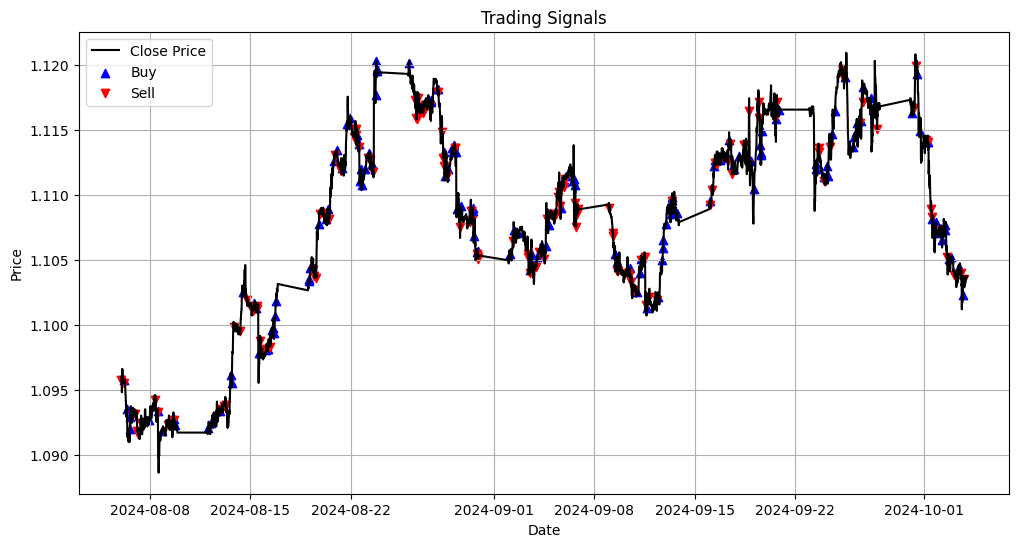

In [ ]:
# Initialize a list to store signals
signal = [0]

# Loop through the data to generate signals
for i in range(1, len(dataF)):
    df = dataF[i-1:i+1]
    signal.append(signal_generator(df))

# Add the signal column to your DataFrame
dataF["signal"] = signal

# Plotting the chart with buy (2) and sell (1) signals
plt.figure(figsize=(12, 6))
plt.plot(dataF.index, dataF['Close'], label='Close Price', color='black')

# Plotting buy signals (2) with blue arrows
plt.scatter(dataF.index[dataF['signal'] == 2],
            dataF['Close'][dataF['signal'] == 2],
            marker='^', color='blue', label='Buy')

# Plotting sell signals (1) with red arrows
plt.scatter(dataF.index[dataF['signal'] == 1],
            dataF['Close'][dataF['signal'] == 1],
            marker='v', color='red', label='Sell')

plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install apscheduler
!pip install oandapyV20
!pip install oanda-candles

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=69778 sha256=bacc735eaa272920281e2cf5b4e89d1a15859f4b8b6fcb85ca3791ed24d59f76
  Stored in directory: /root/.cache/pip/wheels/8e/69/ab/a6da84a85b9bf3b5a98ca15c6c52b7854f32b10c70fe0531a1
Successfully built oandapyV20
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 6.6 MB/s eta 0:00:00
  Created wheel for oandapyV20: filename=oandapyV20-0.6.3-py3-none-any.whl size=69501 sha256=87df6d981bfdcd4b9f484b5b902bf826038d52e9b65ba4d49f5b27173a6b2bc9
  Stored in directory: /root/.cache/pip/wheels/15/56/f0/9bc4a64eebce1

### 3 - Connect to the market and execute trades

In [ ]:
from apscheduler.schedulers.blocking import BlockingScheduler
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleClient
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails

In [ ]:
!pip install apscheduler oandapyV20 oanda-candles

In [ ]:
 access_token='e3d17a57f47e9df5358499ca6b94c2b3-7a24427349180e6b0456327dd28266ec'#you need token here generated from OANDA account
def get_candles(n):
    client = CandleClient(access_token, real=False)
    collector = client.get_collector(Pair.EUR_USD, Gran.M15)
    candles = collector.grab(n)
    return candles

candles = get_candles(3)
for candle in candles:
    print(float(str(candle.bid.o))>1)

True
True
True


In [ ]:
def trading_job():
    candles = get_candles(3)
    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])

    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    signal = signal_generator(dfstream.iloc[:-1,:])#

    # EXECUTING ORDERS
    accountID = "101-001-30046984-001" #your account ID here
    client = API(access_token)

    SLTPRatio = 2.
    previous_candleR = abs(dfstream['High'].iloc[-2]-dfstream['Low'].iloc[-2])

    SLBuy = float(str(candle.bid.o))-previous_candleR
    SLSell = float(str(candle.bid.o))+previous_candleR

    TPBuy = float(str(candle.bid.o))+previous_candleR*SLTPRatio
    TPSell = float(str(candle.bid.o))-previous_candleR*SLTPRatio

    print(dfstream.iloc[:-1,:])
    print(TPBuy, "  ", SLBuy, "  ", TPSell, "  ", SLSell)
    signal = 2
    #Sell
    if signal == 1:
        mo = MarketOrderRequest(instrument="EUR_USD", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif signal == 2:
        mo = MarketOrderRequest(instrument="EUR_USD", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

### 4 - Executing orders automatically with a scheduler

In [ ]:
trading_job()

scheduler = BlockingScheduler()
scheduler.add_job(trading_job, 'cron', day_of_week='mon-fri', hour='00-23', minute='1,16,31,46', start_date='2022-01-12 12:00:00', timezone='America/Chicago')
scheduler.start()

      Open    Close     High      Low
0  1.09677  1.09671  1.09687  1.09660
1  1.09675  1.09653  1.09686  1.09645
1.0973600000000001    1.09613    1.09572    1.09695
{'orderCreateTransaction': {'id': '31', 'accountID': '101-001-30046984-001', 'userID': 30046984, 'batchID': '31', 'requestID': '79305629341780107', 'time': '2024-10-04T18:24:38.367574442Z', 'type': 'MARKET_ORDER', 'instrument': 'EUR_USD', 'units': '1000', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'takeProfitOnFill': {'price': '1.09736', 'timeInForce': 'GTC'}, 'stopLossOnFill': {'price': '1.09613', 'timeInForce': 'GTC', 'triggerMode': 'TOP_OF_BOOK'}, 'reason': 'CLIENT_ORDER'}, 'orderFillTransaction': {'id': '32', 'accountID': '101-001-30046984-001', 'userID': 30046984, 'batchID': '31', 'requestID': '79305629341780107', 'time': '2024-10-04T18:24:38.367574442Z', 'type': 'ORDER_FILL', 'orderID': '31', 'instrument': 'EUR_USD', 'units': '1000', 'requestedUnits': '1000', 'price': '1.09688', 'pl': '0.0000', 'quotePL': '0', 

KeyboardInterrupt: 